# **Deep Learning Homework 5: *Autoencoders***
### MSc Computer Science, Data Science, Cybersecurity Computer Engeneering @UniPD
### 2nd semester - 6 ECTS
### Prof. Alessandro Sperduti & Prof. Nicolò Navarin and Dr. Luca Pasa
---


In this homework, we will deal with _dimensionality reduction_ and learn how to develop a simple _Autoencoder_.
In the first part, we will learn how to develop a simple shallow autoencoder, then we will develop a deep version. Finally, we will experiment with the application of autoencoder on denoising data task (denoising-autoencoder). 

#Requirements

In [1]:
!pip3 install datasets skorch pandas~=1.5 torch~=1.13 torchinfo torchdata~=0.5 torchtext~=0.14 torchvision~=0.14 torchaudio~=0.13 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 624.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 63.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 48.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 37.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━

#Imports

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torchinfo import summary
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from timeit import default_timer as timer
import warnings
warnings.filterwarnings("ignore")

# Data Loading

We load the `CIFAR-10 dataset`, available from `torchvision.datasets`. This dataset is one of the most popular benckmark in the filed of Computer Vision. It consits of $10$ different classes, that represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. The dataset contains $50,000$ training images and $10,000$ images for testing. 

First, we will pre-process them with a `PreProcessing` fuction that works in the following way. The images are originally in RGB format, but we will convert them to grayscale for convenience. The value of each pixel is between $0$ and $255$, and it represents a point of an image of size $32\times32$. We will normalize all values between $0$ and $1$, and we will flatten the $32\times32$ images into vectors of size $1024$.
Moreover, since no validation set is defined, we split the train set in a validation set and a new test set.
Finally, we design a custom dataset class, derived from the standard `Dataset` class, that returns a PyTorch Dataset object, along with its noisy version. The Gaussian noise is tunable with the `noise_factor` parameter and will be used for the Denoising Autoencoder.

In [3]:
to_tensor = transforms.ToTensor()

def PreProcessing(img):
  img = to_tensor(img) #PIL to tensor + Scaling
  img = torch.mean(img, 0) #One channel averaged over the colors
  img = img.reshape(torch.prod(torch.tensor(img.shape))) #Flattening
  return img.to(torch.float32)

In [4]:
dataset = CIFAR10(root='data/', download=True, train=True, transform=transforms.Lambda(PreProcessing)) # 50000 samples
test_data = CIFAR10(root='data/', download=True, train=False, transform=transforms.Lambda(PreProcessing)) # 10000 samples

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data/
Files already downloaded and verified


In [5]:
val_size = 10000
train_size = len(dataset) - val_size

train_data, val_data = random_split(dataset, [train_size, val_size])
print(f"Training samples = {len(train_data)} \nValidation samples = {len(val_data)} \nTest samples = {len(test_data)}")

Training samples = 40000 
Validation samples = 10000 
Test samples = 10000


In [6]:
class CustomDataset(Dataset):
  def __init__(self, dataset, noise_factor, device='cpu'):
    super().__init__()
    self.dataset = dataset
    self.nf = noise_factor
  def __len__(self):
    return len(self.dataset)
  def __getitem__(self, idx):
    x, _ = self.dataset[idx]
    x_noisy = x + self.nf*np.random.normal(loc=0.0, scale=1.0, size=x.shape)
    x_noisy = np.clip(x_noisy, 0., 1.).to(torch.float32)
    return (x.to(device), x_noisy.to(device))

In [7]:
# Set niose factor for later
noise_factor = 0.1

# [TO COMPLETE] SVD

Similar to Principal component analysis (PCA), Singular Value Decomposition (SVD) is a standard linear dimensionality reduction method. They both linearly combine the features of the original high-dimensional dataset and project them into a lower-dimensional space, ideally retaing most of thier intrinsic properties.

In this first part of the HW, we will focus our attention on SVD decomposition and its performances. Given a matrix $X$, the SVD decomposes it into the product of two unitary matrices, $V$ and $U$, and a rectangular diagonal matrix of singular values $S$:

$$ X=V \cdot S \cdot U^T.$$

The SVD is already implemented in PyTorch as `torch.linalg.svd`. In our case, the $X$ matrix will represent the training set, where each row is a sample (therefore the number of columns will be the number of input features). However, notice that the $X$ matrix has a huge number of rows (we have 50,000 input samples) and only 784 columns. If you are using the _Colab_ free plan, the quantity of available RAM may not be sufficient to compute the SVD of $X$. Therefore, to ease memory consumption and numerical stability, we resort to one property of the SVD and compute its equivalent version from the matrix $C= X^T \cdot X$, that can be decomposed as:

$$ C= U \cdot S^2 \cdot U^T$$

Since we need just the matrix $U$ to compute the compressed version of our data, this trick turns out to be a quick and good solution.

In [9]:
def svd_k(X, k):
  # k: sets the number of components to keep

  # Compute the matrix C
  C = torch.matmul(X.T, X)
  # SVD decomposition
  U, s_sqr, U_T = torch.linalg.svd(C)
  # Limit the number columns of U to k
  U_k = U[:,:k]
  return U_k

Now we create the dataset ready for the SVD:

In [10]:
device = torch.device("cpu") #for SVD

x_train, x_train_noisy = next(iter(DataLoader(CustomDataset(train_data, noise_factor, device), batch_size=len(train_data))))
x_val, x_val_noisy = next(iter(DataLoader(CustomDataset(val_data, noise_factor, device), batch_size=len(val_data))))
x_test, x_test_noisy = next(iter(DataLoader(CustomDataset(test_data, noise_factor, device), batch_size=len(test_data))))

x_train.shape, x_train_noisy.shape, x_val.shape, x_val_noisy.shape, x_test.shape, x_test_noisy.shape

(torch.Size([40000, 1024]),
 torch.Size([40000, 1024]),
 torch.Size([10000, 1024]),
 torch.Size([10000, 1024]),
 torch.Size([10000, 1024]),
 torch.Size([10000, 1024]))

Let's define the ENCODING_DIM, that will be the size of the compressed version of input data. And compute the compressed version of the training set and test set.


In [11]:
ENCODING_DIM = 256 #[TO COMPLETE]

U_k = svd_k(x_train, ENCODING_DIM)

x_training_svd = torch.matmul(x_train, U_k)
x_test_svd = torch.matmul(x_test, U_k)

We now reconstruct back the original input and check how much information was lost due to the compression. We do so by computing the mean squared error between the original input and the reconstruction, and by plotting the reconstructed images.

In [12]:
x_training_reco = torch.matmul(x_training_svd, U_k.T)
x_test_reco = torch.matmul(x_test_svd, U_k.T)

In [13]:
accuracy_train = ((x_train - x_training_reco)**2).mean()
accuracy_test = ((x_test - x_test_reco)**2).mean()

print("Training mse: %.5f" % ( accuracy_train))
print("Test mse: %.5f" % ( accuracy_test))

Training mse: 0.00150
Test mse: 0.00153


In [14]:
def plot_img(n, images_sets: list, title=""):
  plt.figure(figsize=(20, 4))
  for i in range(n):
    for set_idx, images in enumerate(images_sets):
      ax = plt.subplot(len(images_sets), n, i + 1 + set_idx*n)
      plt.imshow(images[i].reshape(32, 32))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
  plt.suptitle(title)
  plt.show()

Let's see how well the input can be reconstructed by displaying a few of the input images and the corresponding reconstructions. Obviously, all these evaluations have to be done on the test set.

The first row of images corresponds to input data, while the second one contains the reconstructions.

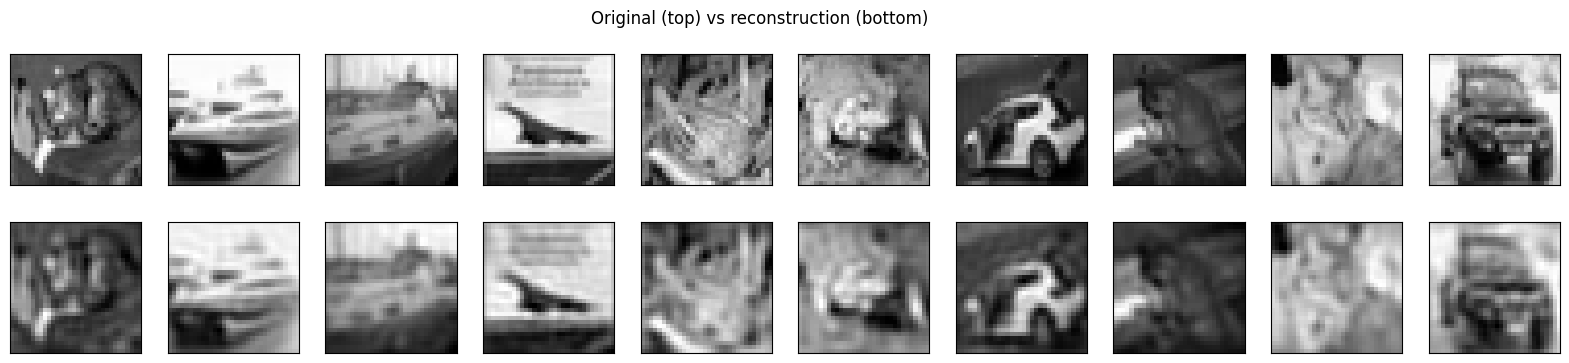

In [14]:
_ = plot_img(10, [x_test, x_test_reco], title="Original (top) vs reconstruction (bottom)")


**[TO COMPLETE]**: What happens by varying the ENCODING_DIM?
 Test and discuss the results in a cell below.

`%STARTEXT`

**ANSWER**: The ENCODING_DIM determines the level of compression and the quality of the reconstruction. It represents the number of columns of U that are preserved in the truncated matrix U_k after performing SVD on the input matrix X.
Modifying the encoding dimension (k) allows to find a good balance between compression and reconstruction quality. A higher value for the encoding dimension preserves more components with the result of a more faithful representation of the original data and higher reconstruction quality. So the closer the k is to the sample dimension, the more accurate the reconstruction is.
On the other hand, reducing the encoding dimension leads to a more compact representation losing more information, with the result of a lower quality output.


`%ENDEXT`

# [TO COMPLETE] Shallow Linear Autoencoder

Let's define a model that consists of a single fully-connected neural layer. The hidden layer and the output layer act as the encoder and the decoder, respectively. First, we define the `DataLoader` to train the model.

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 512
noise_factor = 0.1 # adjust the noise level here.

dataloader_train_AE = DataLoader(CustomDataset(train_data, noise_factor, device), batch_size = batch_size)
dataloader_val_AE = DataLoader(CustomDataset(val_data, noise_factor, device), batch_size = batch_size)
dataloader_test_AE = DataLoader(CustomDataset(test_data, noise_factor, device), batch_size = batch_size)

Then, we build our shallow Autoencoder. Here's a breakdown of the code to help you grasp how it works:

1. The `__init__` method is the initialization function for the Auto_Encoder class. It takes four parameters: `input_dim` (dimensionality of the input data), `enc_layers` (a list specifying the sizes of the encoder layers), `dec_layers` (a list specifying the sizes of the decoder layers), and `act_fun` (the activation function to be used).

2. The `nn.ModuleList()` is used to create empty lists E_layers and D_layers to store the encoder and decoder layers, respectively.

3. The `for loop `iterates over the `enc_layers` list to create the encoder layers. For the first layer, it creates a linear layer (`nn.Linear`) mapping from the input dimension to the size of the first encoder layer. For subsequent layers, it creates linear layers mapping between consecutive encoder layer sizes. The created layers are appended to the `self.E_layers` list.

4. The code then checks if the `dec_layers` list is empty. If it is empty, it creates a single linear layer mapping from the last encoder layer size to the input dimension (remember: the goal of the AE is to reconstruct the input). Otherwise, it iterates over the `dec_layers` list to create the decoder layers, similar to how the encoder layers were created. The last decoder layer is always mapped to the input dimension.

5. The `_init_weights` method is a helper function that initializes the weights of the linear layers. It is applied to all modules (layers) of the Auto_Encoder instance.

6. The `forward` method defines the forward pass of the Autoencoder.

In [21]:
class Auto_Encoder(nn.Module):
  
  def __init__(self, input_dim, enc_layers, dec_layers, act_fun):
    super().__init__()

    self.E_layers = nn.ModuleList()
    self.D_layers = nn.ModuleList()
    self.act_fun = act_fun
    activation_functions = {'linear': transforms.Lambda(lambda x: x),
                            'sigmoid': F.sigmoid,
                            'relu': F.relu,
                            'tanh': F.tanh,
                            'leaky_relu': F.leaky_relu}
    assert self.act_fun in activation_functions, f'Activation Functions: {activation_functions.keys()}'
    self.af = activation_functions[self.act_fun]

    for layer_idx in range(len(enc_layers)):
      if layer_idx == 0:  # first layer, from input to enc
        self.E_layers = self.E_layers.append(nn.Linear(input_dim, enc_layers[layer_idx]))
      else:  # hidden layers, depending on the input
        self.E_layers = self.E_layers.append(nn.Linear(enc_layers[layer_idx-1], enc_layers[layer_idx]))

    if len(dec_layers) == 0:
      self.D_layers = self.D_layers.append(nn.Linear(enc_layers[-1], input_dim))
    else:
      for layer_idx in range(len(dec_layers)):
        if layer_idx == 0:  # first layer, from enc to dec
          self.D_layers = self.D_layers.append(nn.Linear(enc_layers[-1], dec_layers[layer_idx]))
        else:  # hidden layers, depending on the input
          self.D_layers = self.D_layers.append(nn.Linear(dec_layers[layer_idx-1], dec_layers[layer_idx]))
    
      self.D_layers = self.D_layers.append(nn.Linear(dec_layers[-1], input_dim)) # final output layer
    
    self.apply(self._init_weights)
    
  def _init_weights(self, module):
    if isinstance(module, nn.Linear):
        module.weight.data.normal_(mean=0.0, std=.1)
        if module.bias is not None:
            module.bias.data.zero_()
  
  def forward(self, x):
    for layer in self.E_layers:
      x = self.af(layer(x))
    for layer in self.D_layers[:-1]:
      x = self.af(layer(x))
    if self.act_fun == 'linear':
      return self.D_layers[-1](x)
    else:
      return F.sigmoid(self.D_layers[-1](x)) #last act func is always sigmoid

**[TO COMPLETE]** Check the results and compare them with the ones obtained with the SVD. In the cell at the end of this section (after the result of the linear autoencoder), give an explanation of the relation between the results obtained  by the shallow linear autoencoder and the ones obtained by the SVD decomposition. 

Try also to be aquainted with the usual PyTorch training and evaluation routines. In the following part of the HW, the more training epochs the better the resutls, but it will also take longer. Feel free to change the `epochs` variable, just be consistent to make fair comparisons.

In [22]:
IN_DIM = x_train.shape[-1]
ENC_LAYERS = [256] 
DEC_LAYERS = [] 
ACT_FUN = 'linear'
lr = 0.005
epochs = 30 # Feel free to lower this to speed up the training times. Nevertheless, do not go below 25 epochs.

Shallow_AE = Auto_Encoder(IN_DIM, ENC_LAYERS, DEC_LAYERS, ACT_FUN).to(device)
summary(Shallow_AE, input_size=(batch_size, IN_DIM))

Layer (type:depth-idx)                   Output Shape              Param #
Auto_Encoder                             [512, 1024]               --
├─ModuleList: 1-1                        --                        --
│    └─Linear: 2-1                       [512, 256]                262,400
├─ModuleList: 1-2                        --                        --
│    └─Linear: 2-2                       [512, 1024]               263,168
Total params: 525,568
Trainable params: 525,568
Non-trainable params: 0
Total mult-adds (M): 269.09
Input size (MB): 2.10
Forward/backward pass size (MB): 5.24
Params size (MB): 2.10
Estimated Total Size (MB): 9.44

In [23]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(Shallow_AE.parameters(), lr=lr)

In [24]:
def train(model, optimizer, dataloader_train, dataloader_val, epochs, denoising=False):
  loss_train, loss_val = [], []
  for epoch in range(epochs):

    model.train()
    total_count_train, n_train_batches, total_loss_train = 0, 0, 0
    for idx, (x, x_noisy) in enumerate(dataloader_train):
      optimizer.zero_grad()
      if denoising:
        x_rec = model(x_noisy)
      else:
        x_rec = model(x)
      loss = criterion(x_rec, x)
      total_loss_train += loss
      loss.backward()
      optimizer.step()

      total_count_train += x.size(0)
      n_train_batches += 1

    avg_loss_train = total_loss_train/n_train_batches
    loss_train.append(avg_loss_train.item())
    
    total_count_val, n_val_batches, total_loss_val = 0, 0, 0
    with torch.no_grad():
        model.eval()
        for idx, (x, x_noisy) in enumerate(dataloader_val):
            if denoising:
              x_rec = model(x_noisy)
            else:
              x_rec = model(x)

            loss = criterion(x_rec, x)
            total_loss_val += loss
            total_count_val += x.size(0)
            n_val_batches += 1

    avg_loss_val = total_loss_val/n_val_batches
    loss_val.append(avg_loss_val.item())
    if epoch % 1 == 0:
      print(f"epoch: {epoch+1} -> Loss: {avg_loss_train:.8f}",end=" ---------------- ")
      print(f"Val_Acc: Val_Loss: {avg_loss_val:.8f}")
  return loss_train, loss_val

In [20]:
start = timer()
loss_train, loss_val = train(Shallow_AE, optimizer, dataloader_train_AE,
                             dataloader_val_AE, epochs)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Loss: 0.87951142 ---------------- Val_Acc: Val_Loss: 0.24619602
epoch: 2 -> Loss: 0.18832678 ---------------- Val_Acc: Val_Loss: 0.14820516
epoch: 3 -> Loss: 0.12111467 ---------------- Val_Acc: Val_Loss: 0.10196277
epoch: 4 -> Loss: 0.08688750 ---------------- Val_Acc: Val_Loss: 0.07622980
epoch: 5 -> Loss: 0.06682786 ---------------- Val_Acc: Val_Loss: 0.05959896
epoch: 6 -> Loss: 0.05293521 ---------------- Val_Acc: Val_Loss: 0.04848313
epoch: 7 -> Loss: 0.04364114 ---------------- Val_Acc: Val_Loss: 0.04016853
epoch: 8 -> Loss: 0.03643683 ---------------- Val_Acc: Val_Loss: 0.03403398
epoch: 9 -> Loss: 0.03122008 ---------------- Val_Acc: Val_Loss: 0.02939560
epoch: 10 -> Loss: 0.02693258 ---------------- Val_Acc: Val_Loss: 0.02570217
epoch: 11 -> Loss: 0.02385486 ---------------- Val_Acc: Val_Loss: 0.02280889
epoch: 12 -> Loss: 0.02131221 ---------------- Val_Acc: Val_Loss: 0.02054678
epoch: 13 -> Loss: 0.01899946 ---------------- Val_Acc: Val_Loss: 0.01848628
epoch: 1

In [33]:
def plot_learning_acc_and_loss(loss_tr, loss_val):
    info = {'loss_training':loss_tr, 'loss_validation':loss_val}
    df = pd.DataFrame(info)
    df.plot(figsize=(10, 8), subplots=[('loss_training','loss_validation')], grid=True)
    plt.xlabel("Epochs")
    plt.show()

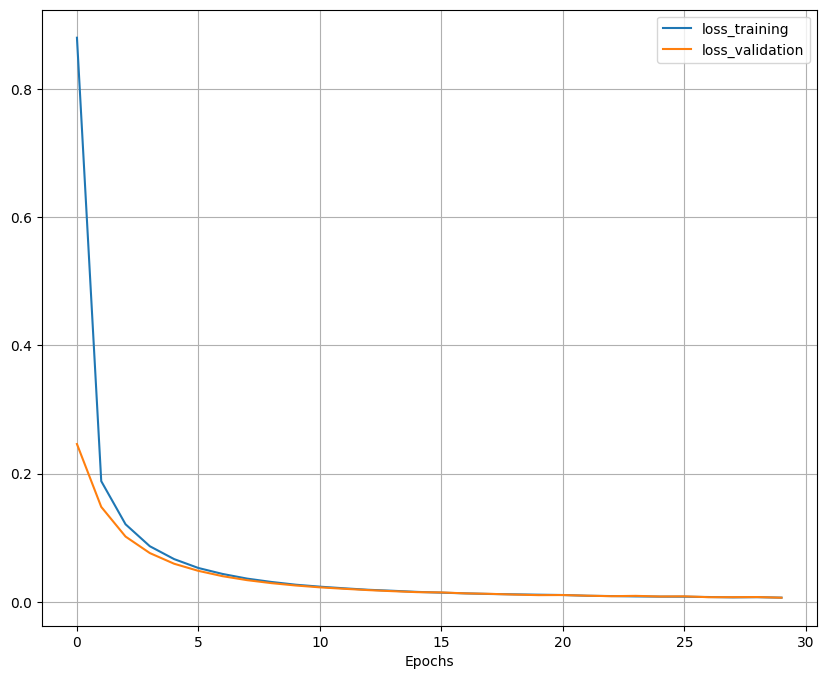

In [22]:
plot_learning_acc_and_loss(loss_train, loss_val)

In [36]:
def test(model, dataloader_test=dataloader_test_AE, denoising=False): #dataloader_test_AE not train
  model.eval()
  total_count_test, n_batches_test, loss = 0, 0, 0
  for idx, (x, x_noisy) in enumerate(dataloader_test):
      if denoising:
        x_rec = model(x_noisy)
      else:
        x_rec = model(x)
      loss += criterion(x_rec, x)
      total_count_test += x.size(0)
      n_batches_test += 1
  loss_test = loss/n_batches_test
  print(f"Test Loss: {loss_test:.8f}")

In [24]:
test(Shallow_AE)

Test Loss: 0.00658929


In [37]:
@torch.no_grad()
def apply_on_test(model, device, denoising=False):
  if denoising:
    x = x_test_noisy.to(device)
  else:
    x = x_test.to(device)
  for layer in model.E_layers:
      x = model.af(layer(x))
  encoded_imgs = x


  y = encoded_imgs
  for layer in model.D_layers[:-1]:
      y = model.af(layer(y))
  if model.act_fun == 'linear':
    decoded_imgs = model.D_layers[-1](y)
  else:
    decoded_imgs = F.sigmoid(model.D_layers[-1](y))

  return (encoded_imgs.to("cpu"), decoded_imgs.to("cpu"))

In [26]:
encoded_imgs, decoded_imgs = apply_on_test(model=Shallow_AE, device=device)

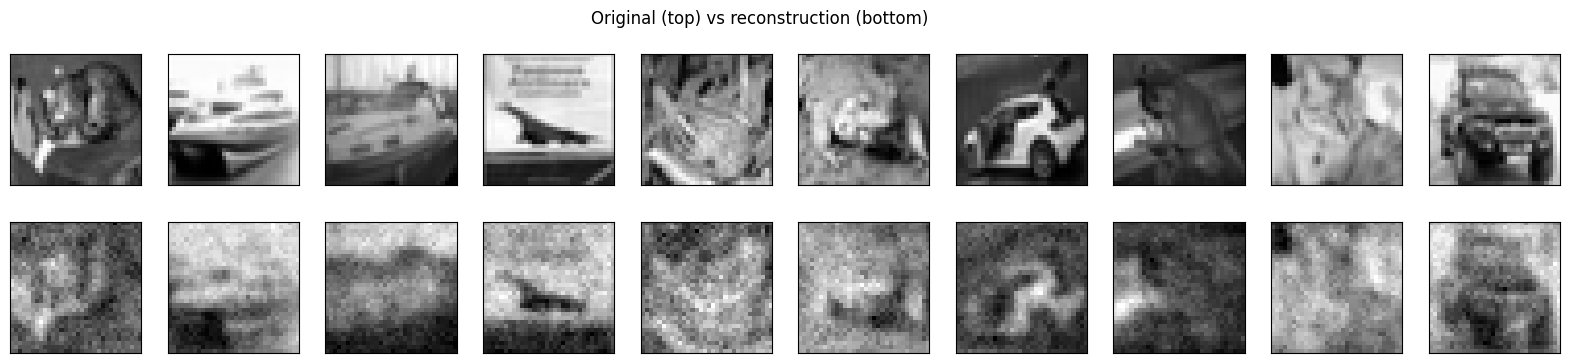

In [27]:
plot_img(10, [x_test, decoded_imgs], title="Original (top) vs reconstruction (bottom)")

Comment the results obtained with the shallow linear autoencoder in relation to the ones obtained by the SVD decomposition. Are they different or similar? Why do you think they are so? (hint: consider the theoretical relationship between SVD and a shallow linear autoencoder.)

`%STARTEXT`

**ANSWER**:A shallow linear autoencoder with a single hidden layer and linear activation function should perform almost in an equivalent way SVD decomposition on the input data. Both approaches have the purpose of finding a low-dimensional representation by capturing the most important components. SVD provides an exact representation using the singular value matrix, while the autoencoder learns to approximate the input data. With linear activation, the autoencoder performs a linear transformation, aligning with SVD's linear transformations. So it is possible to conlcude that the reconstructed outputs should be similar. However, autoencoders can incorporate non-linear activations and this leads to a flexibility that SVD lacks.

`%ENDTEXT`

# [TO COMPLETE] Shallow non-linear Autoencoder

**[TO COMPLETE]** Replicate the code of the previous exercise but in this case, instead of using linear activation functions use non-linear ones. Choose the most appropriate non-linear function, and motivate your choice in the last cell of this section. Discuss the results you obtained in relation to those obtained with the Shallow Linear Autoencoder.

`%STARTCODE`

In [58]:
IN_DIM = x_train.shape[-1]
ENC_LAYERS = [256] 
DEC_LAYERS = [] 
ACT_FUN = 'sigmoid'
lr = 0.005
epochs = 25 # [TO COMPLETE]
# define model and training hyperparameters
# END

Shallow_non_AE = Auto_Encoder(IN_DIM, ENC_LAYERS, DEC_LAYERS, ACT_FUN).to(device)
summary(Shallow_non_AE, input_size=(batch_size, IN_DIM))

Layer (type:depth-idx)                   Output Shape              Param #
Auto_Encoder                             [512, 1024]               --
├─ModuleList: 1-1                        --                        --
│    └─Linear: 2-1                       [512, 256]                262,400
├─ModuleList: 1-2                        --                        --
│    └─Linear: 2-2                       [512, 1024]               263,168
Total params: 525,568
Trainable params: 525,568
Non-trainable params: 0
Total mult-adds (M): 269.09
Input size (MB): 2.10
Forward/backward pass size (MB): 5.24
Params size (MB): 2.10
Estimated Total Size (MB): 9.44

In [59]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(Shallow_non_AE.parameters(), lr=lr)

In [60]:
start = timer()
loss_train, loss_val = train(Shallow_non_AE, optimizer, dataloader_train_AE,
                             dataloader_val_AE, epochs)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Loss: 0.04000399 ---------------- Val_Acc: Val_Loss: 0.02611511
epoch: 2 -> Loss: 0.02191558 ---------------- Val_Acc: Val_Loss: 0.01965285
epoch: 3 -> Loss: 0.01824015 ---------------- Val_Acc: Val_Loss: 0.01855863
epoch: 4 -> Loss: 0.01468013 ---------------- Val_Acc: Val_Loss: 0.01305893
epoch: 5 -> Loss: 0.01416682 ---------------- Val_Acc: Val_Loss: 0.01209342
epoch: 6 -> Loss: 0.01262534 ---------------- Val_Acc: Val_Loss: 0.01261578
epoch: 7 -> Loss: 0.01079276 ---------------- Val_Acc: Val_Loss: 0.01110895
epoch: 8 -> Loss: 0.01028598 ---------------- Val_Acc: Val_Loss: 0.00954268
epoch: 9 -> Loss: 0.00967625 ---------------- Val_Acc: Val_Loss: 0.00924373
epoch: 10 -> Loss: 0.00931993 ---------------- Val_Acc: Val_Loss: 0.00865171
epoch: 11 -> Loss: 0.00893883 ---------------- Val_Acc: Val_Loss: 0.00833540
epoch: 12 -> Loss: 0.00861298 ---------------- Val_Acc: Val_Loss: 0.00885645
epoch: 13 -> Loss: 0.00827219 ---------------- Val_Acc: Val_Loss: 0.00776083
epoch: 1

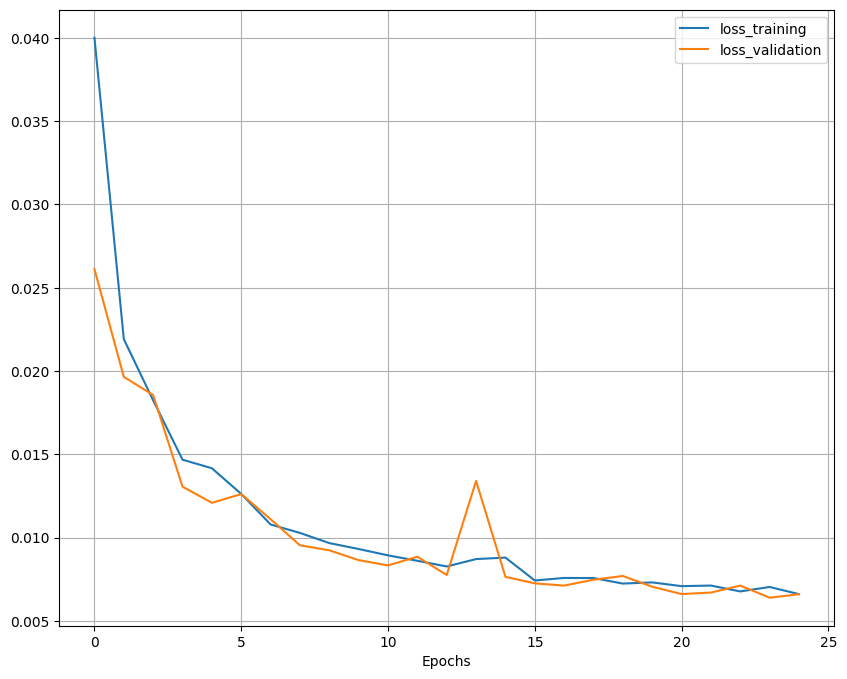

In [61]:
plot_learning_acc_and_loss(loss_train, loss_val)

In [62]:
test(Shallow_non_AE)

Test Loss: 0.00658873


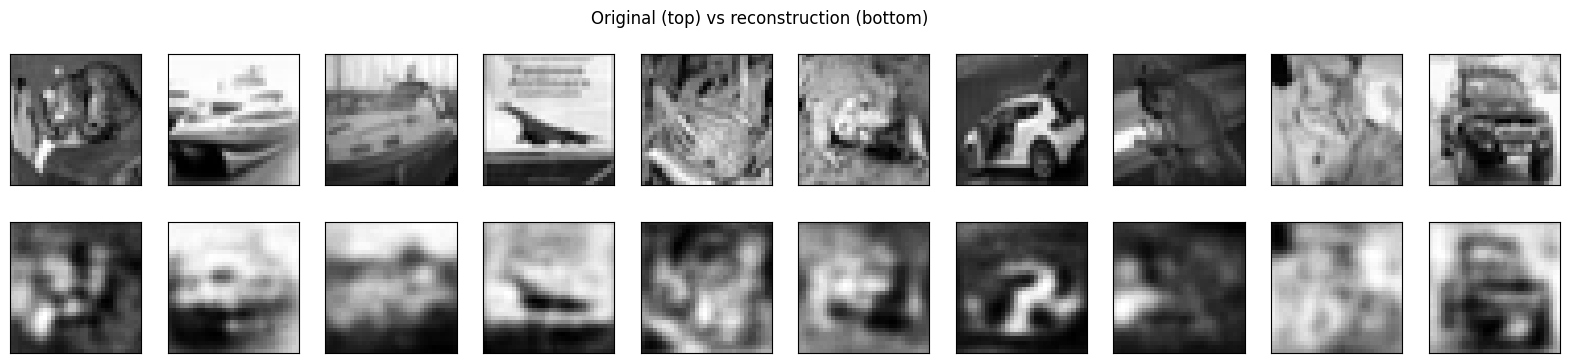

In [63]:
encoded_imgs, decoded_imgs = apply_on_test(model=Shallow_non_AE, device=device)

plot_img(10, [x_test, decoded_imgs], title="Original (top) vs reconstruction (bottom)")

`%ENDCODE`

Discuss the results you obtained with the activation functions you have tested and also motivate your choice. Compare your results to the ones obtained with the Shallow Linear Autoencoder.

`%STARTEXT`

**ANSWER**:

*   **Activation function: Sigmoid**
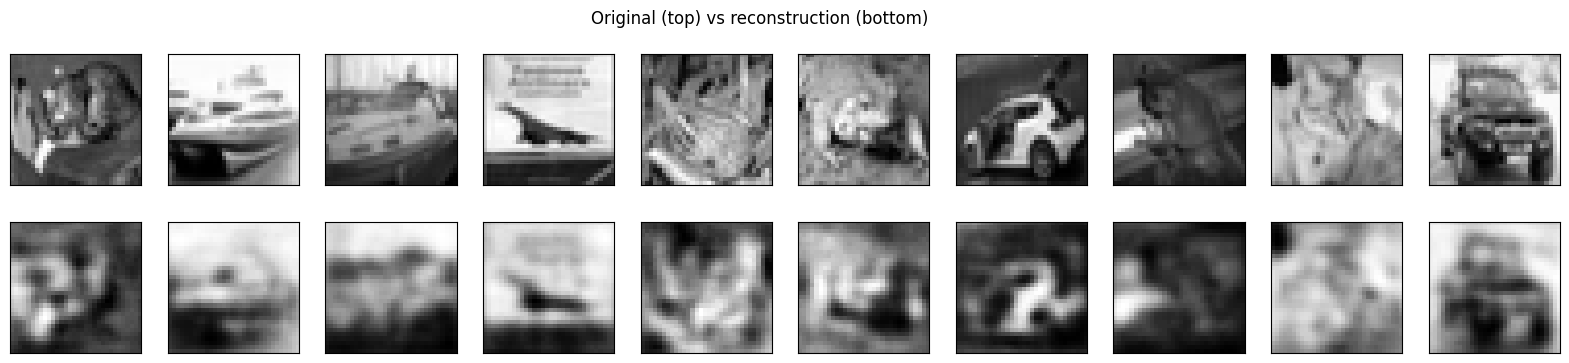
*   **Activation function: Tanh**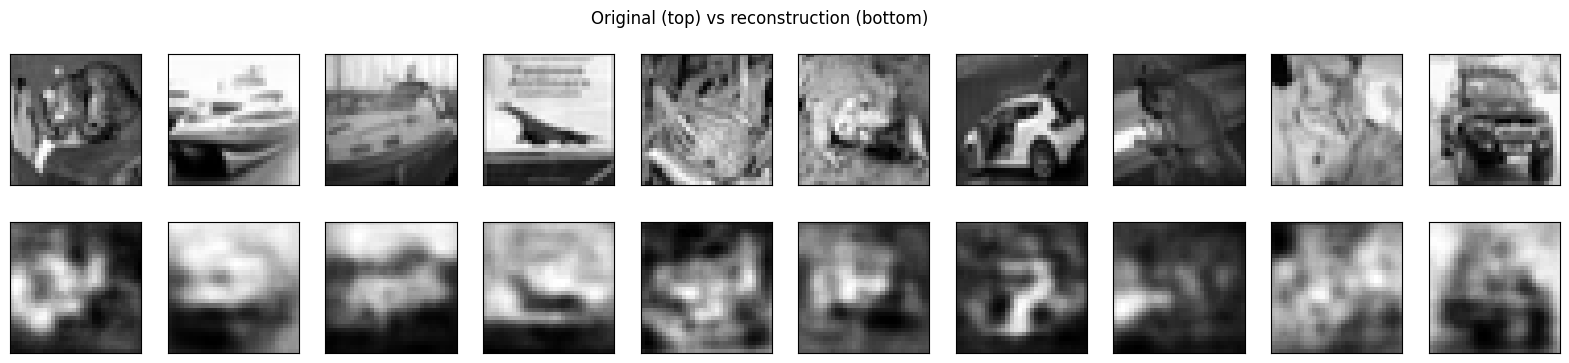
*   **Activation function: Relu**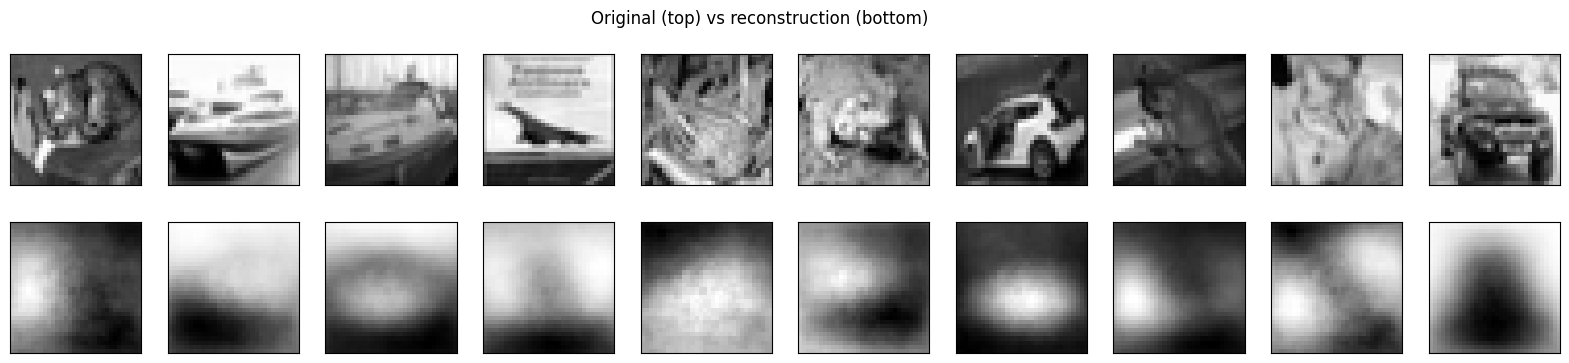
*   **Activation function: Leaky-Relu**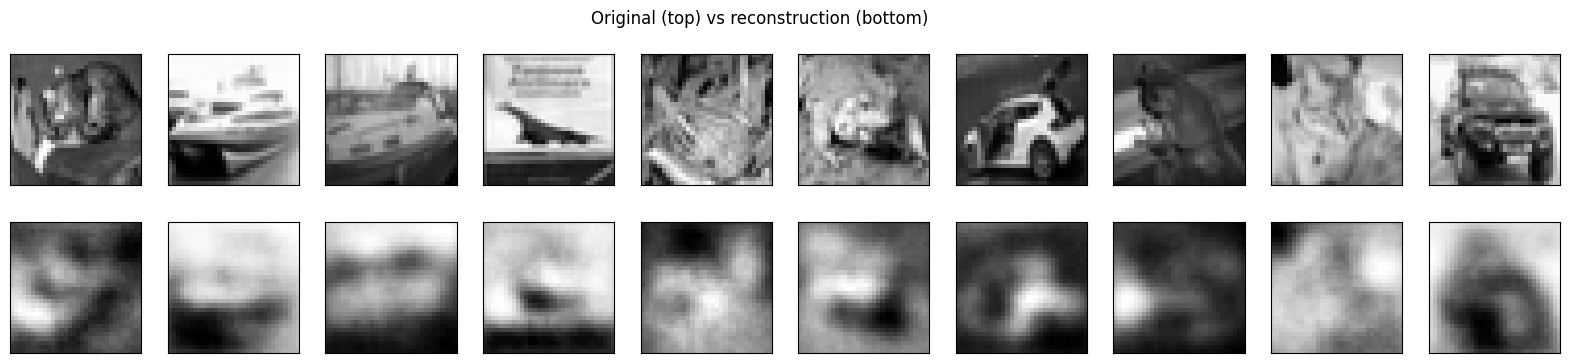

After testing the four different activation functions with 25 epochs, the results are as follows:

SIGMOID: The test loss reached a value of 0.00737944. The loss plot shows a smooth decrease during training. The reconstructed images, even though appear blurry, is the best compared to other ones. This blurriness may be due to the limited expressive power of the sigmoid activation function, which compresses the input values into the range [0, 1].

TANH: The test loss for tanh was higher than sigmoid, reaching 0.00952311. The loss plot shows a non-smooth decrease, indicating potential challenges during training. The reconstructed images are also difficult to interpret due to the limitations of the tanh activation function. Similar to sigmoid, the tanh function compresses input values into a limited range. Consequently, the reconstructed images lack clarity and fine details, making them challenging to understand.

RELU: The test loss obtained with ReLU was the highest, measuring 0.01430835. Despite the smooth loss plot, the reconstructed images are the worst in terms of quality, with nothing identifiable. This can be attributed to the "dying ReLU" problem, where a large number of activations become zero, leading to limited learning and weak reconstruction capabilities.

LEAKY_RELU: The test loss for leaky ReLU is higher than sigmoid, measuring 0.01030195.The reconstructed images with leaky ReLU are comparatively better than ReLU but still have areas of dark and light with no clear subject. The introduction of a small positive slope for negative inputs in leaky ReLU helps mitigate the "dying ReLU" problem, allowing for better gradient flow. 

At the end the best results were the ones obtained with the sigmoid, both in terms of loss values and of better images representation.

Comparing the Shallow Linear Autoencoder and the Shallow Non-Linear Autoencoder, both achieve similar test loss values (Test Loss: 0.00658929 vs 0.00737944). However, the reconstructed images differ significantly, The Shallow Linear Autoencoder produces images that are more challenging to interpret than the Shallow Non-Linear Autoencoder. This difference in image quality can be attributed to the limitations of linear transformations in the Shallow Linear Autoencoder. The use of non linear activation function allows to capture more complex non-linear patterns.

`%ENDTEXT`

# [TO COMPLETE] Deep Autoencoder

**[TO COMPLETE]**: Define a deep version of the Autoeancoder defined above. The autoencoder has to **use at least $5$ layers**. The model will use 𝑛 layers for encoding, and $n-1$ for decoding. The layers sizes of the encoding part decrease at each layer (e.g. `IN_DIM` → $k$ → $k/2$, where $k/2$ is the arbitrarly chosen encoding dim). The decoding part layers dimensions progression turns out to be mirrored (i.e., $k$ → `IN_DIM`, the resulting overall structure recalls an hourglass!). Try different hyperparameters configurations and write a short report of your experiments below. Leave the best execution in the code cells.

`%STARTCODE`

In [28]:
IN_DIM = x_train.shape[-1]
ENC_LAYERS = [256, 128, 64] 
DEC_LAYERS = [128,256] 
ACT_FUN = 'tanh'
lr = 0.0005
epochs=30 # [TO COMPLETE]
# define model and training hyperparameters
# END

DEEP_non_AE = Auto_Encoder(IN_DIM, ENC_LAYERS, DEC_LAYERS, ACT_FUN).to(device)
summary(DEEP_non_AE, input_size=(batch_size, IN_DIM))

Layer (type:depth-idx)                   Output Shape              Param #
Auto_Encoder                             [512, 1024]               --
├─ModuleList: 1-1                        --                        --
│    └─Linear: 2-1                       [512, 256]                262,400
│    └─Linear: 2-2                       [512, 128]                32,896
│    └─Linear: 2-3                       [512, 64]                 8,256
├─ModuleList: 1-2                        --                        --
│    └─Linear: 2-4                       [512, 128]                8,320
│    └─Linear: 2-5                       [512, 256]                33,024
│    └─Linear: 2-6                       [512, 1024]               263,168
Total params: 608,064
Trainable params: 608,064
Non-trainable params: 0
Total mult-adds (M): 311.33
Input size (MB): 2.10
Forward/backward pass size (MB): 7.60
Params size (MB): 2.43
Estimated Total Size (MB): 12.13

In [29]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(DEEP_non_AE.parameters(), lr=lr)

In [30]:
start = timer()
loss_train, loss_val = train(DEEP_non_AE, optimizer, dataloader_train_AE,
                             dataloader_val_AE, epochs)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Loss: 0.04101477 ---------------- Val_Acc: Val_Loss: 0.02814852
epoch: 2 -> Loss: 0.02495293 ---------------- Val_Acc: Val_Loss: 0.02245576
epoch: 3 -> Loss: 0.02076117 ---------------- Val_Acc: Val_Loss: 0.02004718
epoch: 4 -> Loss: 0.01863011 ---------------- Val_Acc: Val_Loss: 0.01816076
epoch: 5 -> Loss: 0.01725606 ---------------- Val_Acc: Val_Loss: 0.01689441
epoch: 6 -> Loss: 0.01635903 ---------------- Val_Acc: Val_Loss: 0.01613503
epoch: 7 -> Loss: 0.01567948 ---------------- Val_Acc: Val_Loss: 0.01552510
epoch: 8 -> Loss: 0.01509233 ---------------- Val_Acc: Val_Loss: 0.01501886
epoch: 9 -> Loss: 0.01459530 ---------------- Val_Acc: Val_Loss: 0.01485373
epoch: 10 -> Loss: 0.01415941 ---------------- Val_Acc: Val_Loss: 0.01451364
epoch: 11 -> Loss: 0.01382411 ---------------- Val_Acc: Val_Loss: 0.01371976
epoch: 12 -> Loss: 0.01344556 ---------------- Val_Acc: Val_Loss: 0.01341253
epoch: 13 -> Loss: 0.01314964 ---------------- Val_Acc: Val_Loss: 0.01318170
epoch: 1

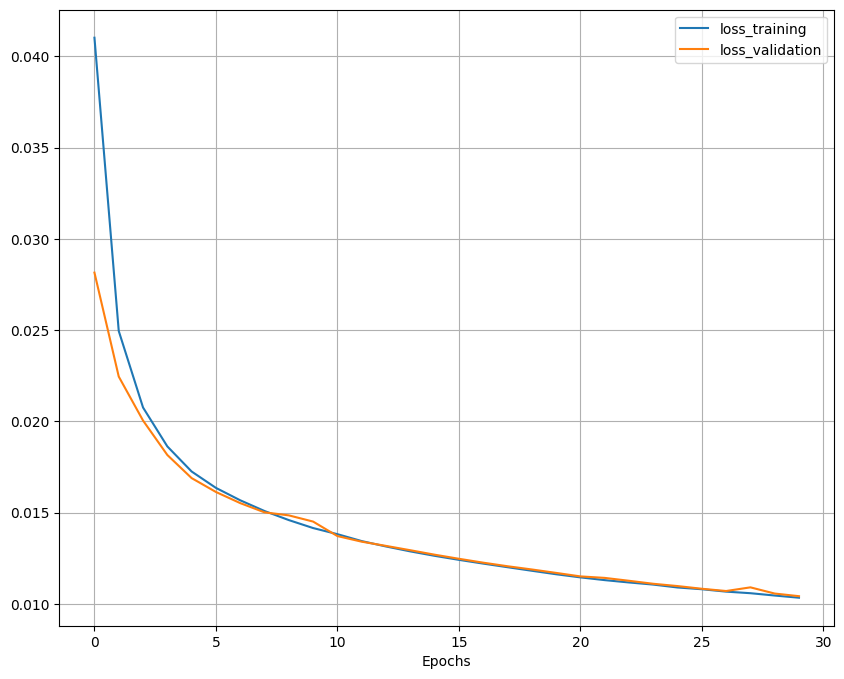

In [34]:
plot_learning_acc_and_loss(loss_train, loss_val)

In [38]:
test(DEEP_non_AE)

Test Loss: 0.01041236


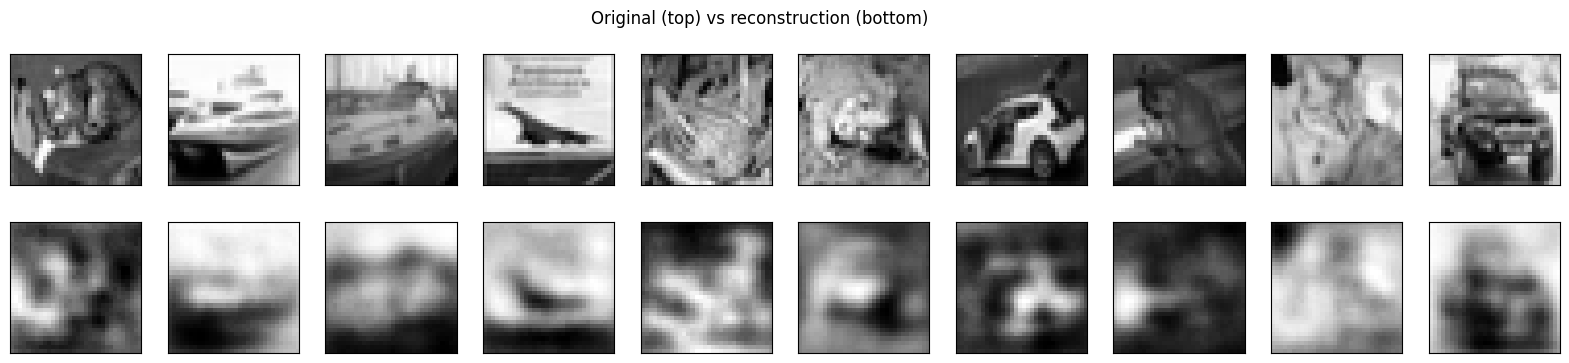

In [39]:
encoded_imgs, decoded_imgs = apply_on_test(model=DEEP_non_AE, device=device)

plot_img(10, [x_test, decoded_imgs], title="Original (top) vs reconstruction (bottom)")

`%ENDCODE`

Write a short report of the results you obtained trying different hyperparameters configurations.

`%STARTEXT`

**ANSWER**: The best model I obtained is the following one: 

ENC_LAYERS = [256, 128, 64]

DEC_LAYERS = [128, 256]

ACT_FUN = 'tanh',

lr= 0.005

with a test loss of: 0.01041236.

Changing from this configuration the activation function to leaky_relu I got another good result with a test loss of 0.01365221.
 However with both the configurations above the representations aren't much clear, but something is recognizable.
I also tried configurations with the sigmoid as activation function. However this function is less suitable when networks become deeper because of the vanishing gradient issue. I even tried to increase the ENC_DIM and changing the dimensions but the images didn't improve and I didn't achive a better performance.
These are two models that got a quite good value for the test loss:

* ENC_LAYERS = [768, 384, 192]

DEC_LAYERS = [384, 768]

ACT_FUN = 'tanh'

lr=0.005

* ENC_LAYERS = [1024, 512, 256]

DEC_LAYERS = [256, 512]

ACT_FUN = 'tanh'

lr=0.002





`%ENDTEXT`

# [TO COMPLETE] Shallow Denoising Autoencoder

**[TO COMPLETE]** Let's now use a shallow autoencoder to denoise the input data. We have defined a Dataloader able to return a noisy version of the input data. You can activate this capability by passing the parameter `denoising=True` to the `train` function.

Run some experiments with different hyperparameters values. You can also re-create the dataloaders at the beginning of the notebook and test what happens if you increase the noise level above $0.1$. Write a short report of your findings below.

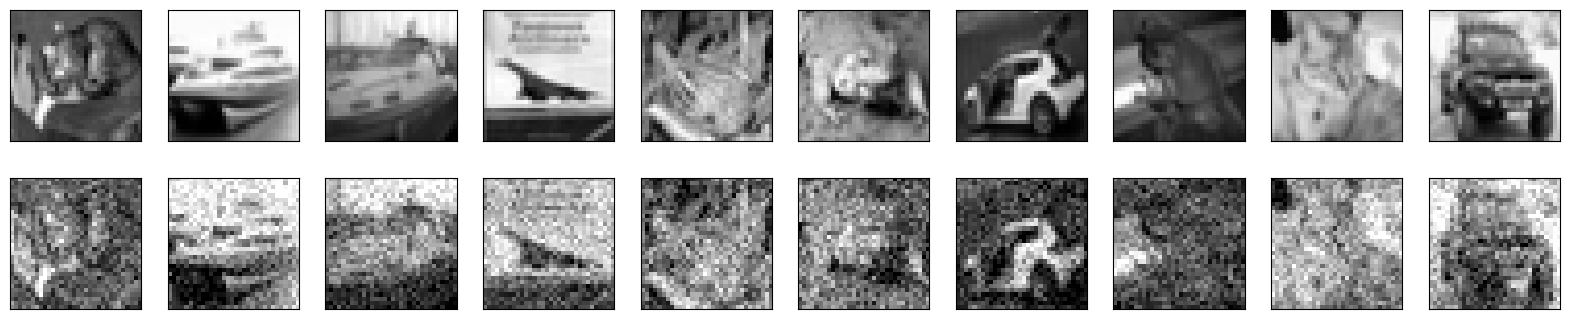

In [40]:
plot_img(10, [x_test, x_test_noisy])

`%STARTCODE`

In [52]:
IN_DIM = x_train.shape[-1]
ENC_LAYERS = [512] 
DEC_LAYERS = [] 
ACT_FUN = 'sigmoid'
lr = 0.005
epochs = 25# [TO COMPLETE]
# define model and training hyperparameters
# END

SHALLOW_denoising_AE = Auto_Encoder(IN_DIM, ENC_LAYERS, DEC_LAYERS, ACT_FUN).to(device)
summary(SHALLOW_denoising_AE, input_size=(batch_size, IN_DIM))

Layer (type:depth-idx)                   Output Shape              Param #
Auto_Encoder                             [512, 1024]               --
├─ModuleList: 1-1                        --                        --
│    └─Linear: 2-1                       [512, 512]                524,800
├─ModuleList: 1-2                        --                        --
│    └─Linear: 2-2                       [512, 1024]               525,312
Total params: 1,050,112
Trainable params: 1,050,112
Non-trainable params: 0
Total mult-adds (M): 537.66
Input size (MB): 2.10
Forward/backward pass size (MB): 6.29
Params size (MB): 4.20
Estimated Total Size (MB): 12.59

In [53]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(SHALLOW_denoising_AE.parameters(), lr=lr)

In [54]:
start = timer()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
noise_factor = 0.1 # adjust the noise level here.

x_train, x_train_noisy =next(iter(DataLoader(CustomDataset(train_data, noise_factor, device), batch_size = batch_size)))
x_val, x_val_noisy  =next(iter(DataLoader(CustomDataset(val_data, noise_factor, device), batch_size = batch_size)))
x_test, x_test_noisy =next(iter(DataLoader(CustomDataset(test_data, noise_factor, device), batch_size = batch_size)))
# [TO COMPLETE]
# call the training function on noisy data
loss_train, loss_val = train(SHALLOW_denoising_AE, optimizer, dataloader_train_AE,
                             dataloader_val_AE, epochs, denoising=True)

end = timer()
print(f"Training time in second: {round(end - start)}")

epoch: 1 -> Loss: 0.04005832 ---------------- Val_Acc: Val_Loss: 0.02487131
epoch: 2 -> Loss: 0.02017684 ---------------- Val_Acc: Val_Loss: 0.01794770
epoch: 3 -> Loss: 0.01748999 ---------------- Val_Acc: Val_Loss: 0.01861006
epoch: 4 -> Loss: 0.01408823 ---------------- Val_Acc: Val_Loss: 0.01284181
epoch: 5 -> Loss: 0.01293192 ---------------- Val_Acc: Val_Loss: 0.01203548
epoch: 6 -> Loss: 0.01145066 ---------------- Val_Acc: Val_Loss: 0.01340198
epoch: 7 -> Loss: 0.01182571 ---------------- Val_Acc: Val_Loss: 0.01308087
epoch: 8 -> Loss: 0.01039110 ---------------- Val_Acc: Val_Loss: 0.00967273
epoch: 9 -> Loss: 0.00972829 ---------------- Val_Acc: Val_Loss: 0.01042232
epoch: 10 -> Loss: 0.00925262 ---------------- Val_Acc: Val_Loss: 0.00875016
epoch: 11 -> Loss: 0.01027810 ---------------- Val_Acc: Val_Loss: 0.00917308
epoch: 12 -> Loss: 0.00860835 ---------------- Val_Acc: Val_Loss: 0.00881901
epoch: 13 -> Loss: 0.00850754 ---------------- Val_Acc: Val_Loss: 0.00812678
epoch: 1

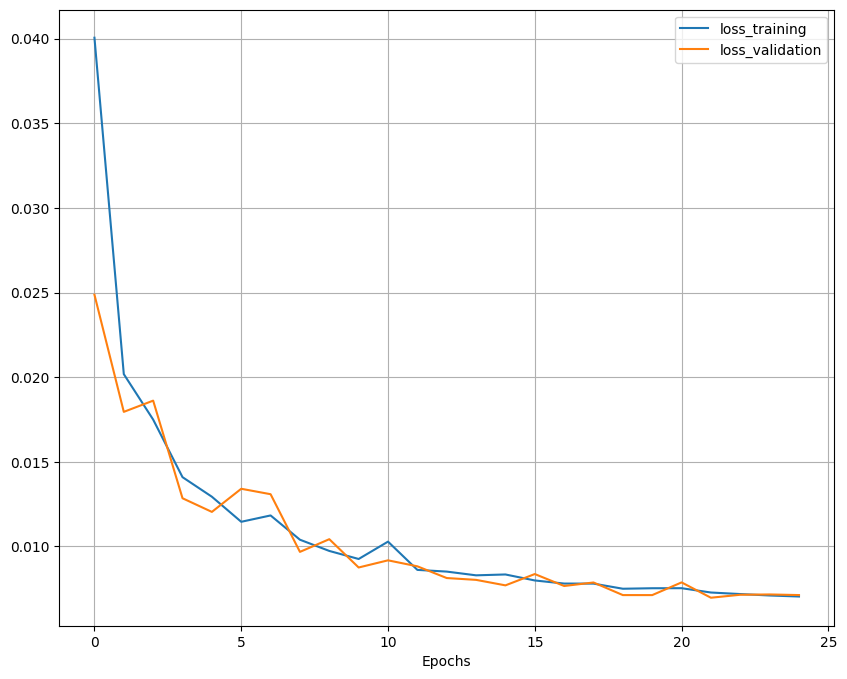

In [55]:
plot_learning_acc_and_loss(loss_train, loss_val)

In [56]:
test(SHALLOW_denoising_AE, denoising=True)

Test Loss: 0.00711476


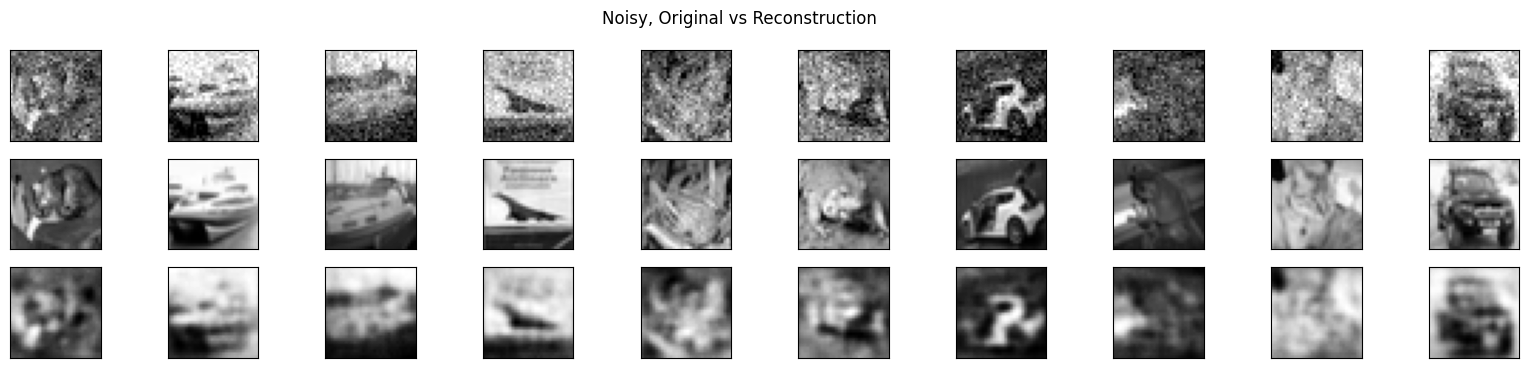

In [57]:
encoded_imgs, decoded_imgs = apply_on_test(model=SHALLOW_denoising_AE, device=device, denoising=True)

plot_img(10, [x_test_noisy, x_test, decoded_imgs], title="Noisy, Original vs Reconstruction")

`%ENDCODE`

How strong is the impact of the noise factor on the model's denoising capability? What hyperparameter configuration worked for the noise levels you have tried?

`%STARTEXT`




**ANSWER**: 
In a shallow denoising autoencoder, the noise factor corresponds to the noise the is added to the input data. Increasing the noise factor adds more noise to the input data, making the reconstruction task more challenging for the autoencoder. This forces the model to learn robust representations that can handle noisy input. It can be beneficial in improving the model's generalization and ability to handle variations in real-world data. However, if the noise factor is set too high, the noise may overpower the original signal, making it difficult for the autoencoder to learn meaningful representations.
Instead, decreasing the noise factor reduces the amount of noise added to the input data, in this way the reconstruction task is easier. This can lead to better reconstruction accuracy, but it may also increase the risk of overfitting. A lower noise factor may lead the model to memorize the training data without effectively learning generalized features.
The noise factor should be selected based on the trade-off between noise resilience and reconstruction quality for the given task.

The best model I obtained is:
ENC_LAYERS = [512]

DEC_LAYERS = []

ACT_FUN = 'sigmoid'

noise_factor = 0.1, with a test loss function of 0.01428604.
These are some of the configurations that I tried, keeping lr=0.005 and epochs=25:



1.  noise_factor= 0.1
*   ENC_LAYERS=[512], DEC_LAYERS=[], ACT_FUN="sigmoid", test_loss=0.00711476
*   ENC_LAYERS=[256], DEC_LAYERS=[], ACT_FUN="sigmoid", test_loss=0.00821661
*   ENC_LAYERS=[512], DEC_LAYERS=[], ACT_FUN="tanh", test_loss=0.011542213
*   ENC_LAYERS=[512], DEC_LAYERS=[], ACT_FUN="leaky_relu", test_loss=0.09998142
*   ENC_LAYERS=[256], DEC_LAYERS=[], ACT_FUN="tanh", test_loss=0.01022889

2.  noise_factor= 0.3
*   ENC_LAYERS=[512], DEC_LAYERS=[], ACT_FUN="sigmoid", test_loss= 0.00911251
*   ENC_LAYERS=[256], DEC_LAYERS=[], ACT_FUN="sigmoid", test_loss= 0.00998172
*   ENC_LAYERS=[512], DEC_LAYERS=[], ACT_FUN="tanh", test_loss=0.01446531

3.  noise_factor= 0.5
*   ENC_LAYERS=[512], DEC_LAYERS=[], ACT_FUN="sigmoid", test_loss= 0.01554122
*   ENC_LAYERS=[512], DEC_LAYERS=[], ACT_FUN="tanh", test_loss= 0.02017354
*   ENC_LAYERS=[512], DEC_LAYERS=[], ACT_FUN="leaky_relu", test_loss= 0.01677421

With each combinations of encoding layer dimension and of noise factor, the better results were achieved with the sigmoid as activation fuction and with ENC_LAYER=[512].As for the presence of the noise factor it can help improving the model generalization and so the quality of the image but if it's too high can prevent the model to efficently reconstruct the original data.


*  noise_factor= 0.1 ENC_LAYERS=[512], DEC_LAYERS=[], ACT_FUN="sigmoid"
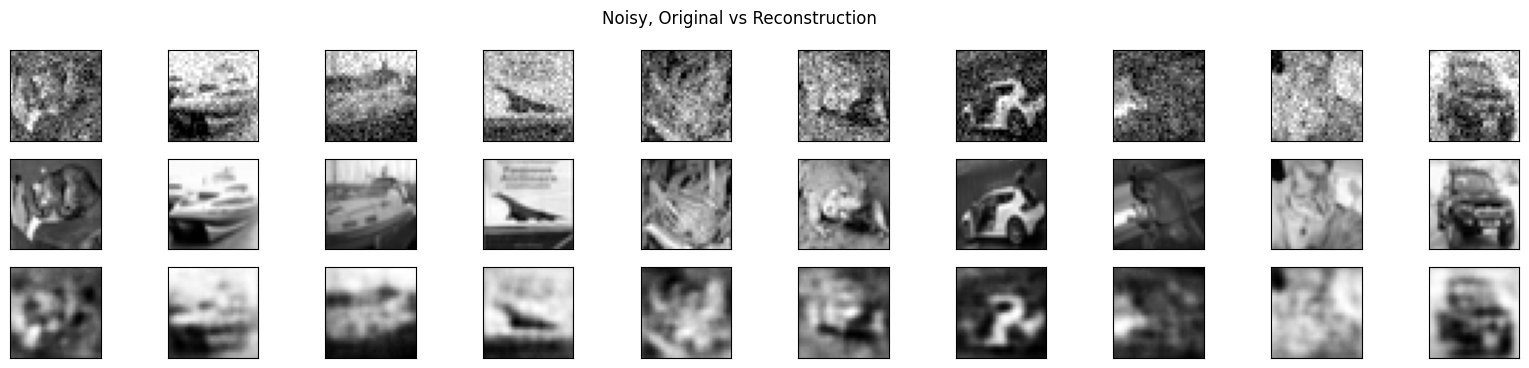


*  noise_factor= 0.3 ENC_LAYERS=[512], DEC_LAYERS=[], ACT_FUN="leaky_relu"
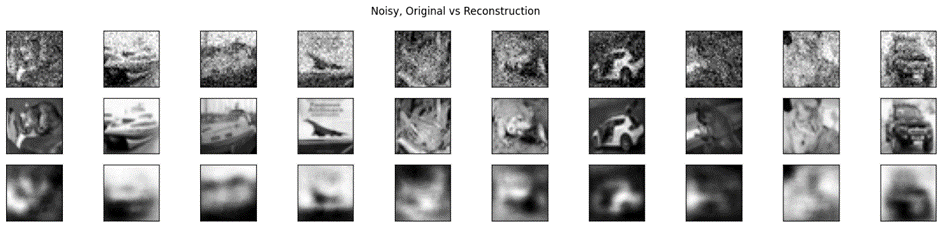

*  noise_factor= 0.5 ENC_LAYERS=[512], DEC_LAYERS=[], ACT_FUN="sigmoid"

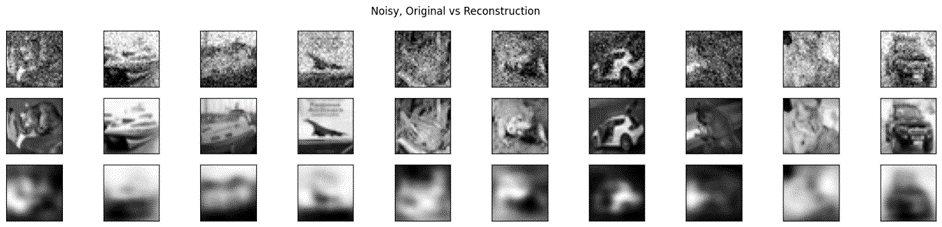



`%ENDTEXT`